<a href="https://colab.research.google.com/github/FinancialEngineerLab/finefinance/blob/master/Technical_Analysis(0615).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install library #
!pip install -U finance_datareader
#!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
#!tar -xzvf ta-lib-0.4.0-src.tar.gz
#%cd ta-lib
#!./configure --prefix=/usr
#!make
#!make install
!pip install quandl

In [ ]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import seaborn
import datetime
import scipy.stats as ss
import quandl
import io
from pylab import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Excel #
'''from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

#df = pd.read_excel('/content/drive/My Drive/Colab Notebook/2018년.xlsx')
#
## Excel Upload #
uploaded = files.upload()'''
#df = pd.read_csv(io.StringIO(uploaded['파일명.csv'].decode('utf-8')))

"from google.colab import drive\nfrom google.colab import files\n\ndrive.mount('/content/drive')\n\n#df = pd.read_excel('/content/drive/My Drive/Colab Notebook/2018년.xlsx')\n#\n## Excel Upload #\nuploaded = files.upload()"

In [ ]:
## Basic Functions ##

now = datetime.datetime.today().strftime('%Y-%m-%d')

## Data MGT ##
def load_financial_data(ticker, start_date, end_date, output_file):
  try:
    df = pd.read_pickle(output_file)
    print('File data found ... reading data')
  except FileNotFoundError:
    print('File not found ... downloading data')
    df = pd.DataFrame(fdr.DataReader(ticker, start_date, end_date))
    df.to_pickle(output_file)
  return df

def zscore(series):
  return (series - series.mean())/ np.std(series)

def zscore_rolling(series, window):
    r = series.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (series-m)/s
    return z

def signal_result(ticker, state_date = '2008-01-01', end_date=now, window = 20, rsi_long_2 = 10, rsi_long_1=25, rsi_short_2=90, rsi_short_1=75):
    # Series Generation
    df_list_1 = fdr.DataReader(ticker,  "2008-01-01","2008-12-31")[['Open','High','Low','Close']]
    df_list_2 = fdr.DataReader(ticker,  "2009-01-01","2009-12-31")[['Open','High','Low','Close']]
    df_list_3 = fdr.DataReader(ticker,  "2010-01-01","2010-12-31")[['Open','High','Low','Close']]
    df_list_4 = fdr.DataReader(ticker,  "2011-01-01","2011-12-31")[['Open','High','Low','Close']]
    df_list_5 = fdr.DataReader(ticker,  "2012-01-01","2012-12-31")[['Open','High','Low','Close']]
    df_list_6 = fdr.DataReader(ticker,  "2013-01-01","2013-12-31")[['Open','High','Low','Close']]
    df_list_7 = fdr.DataReader(ticker,  "2014-01-01","2014-12-31")[['Open','High','Low','Close']]
    df_list_8 = fdr.DataReader(ticker, "2015-01-01","2015-12-31")[['Open','High','Low','Close']]
    df_list_9 =fdr.DataReader(ticker,  "2016-01-01","2016-12-31")[['Open','High','Low','Close']]
    df_list_10 =fdr.DataReader(ticker, "2017-01-01","2017-12-31")[['Open','High','Low','Close']]
    df_list_11 =fdr.DataReader(ticker, "2018-01-01","2018-12-31")[['Open','High','Low','Close']]
    df_list_12 =fdr.DataReader(ticker, "2019-01-01","2019-12-31")[['Open','High','Low','Close']]
    df_list_13 =fdr.DataReader(ticker, "2020-01-01")[['Open','High','Low','Close']]
                
    ### data frame preprocessing ###
    # axis transformation
    # axis = 1이면 cbind, axis = 0이면 rbind
    df_total = pd.concat([df_list_1, df_list_2, df_list_3, df_list_4,df_list_5, df_list_6, df_list_7, df_list_8,
                          df_list_9, df_list_10, df_list_11, df_list_12, df_list_13])
    df_total = df_total[(df_total.index >= start_date) & (df_total.index < end_date)]
    # NA cleaning
    df_raw0 = df_total[['Open','High','Low']]
    df_raw = df_total['Close']
    df_raw = df_raw.fillna(method = 'ffill')

    # time delt calculation
    #close = df_raw['Close']
    delta = df_raw.diff()
    delta = delta[1:]

    ### RSI Calculation ###
    
    # + gain, - gain
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    # EWMA + RSI
    roll_up1 = up.ewm(span = window).mean()
    roll_down1 = down.abs().ewm(span = window).mean()
    RSI_em = roll_up1 / roll_down1
    RSI_ewm = 100.0 - (100.0 / (1.0 + RSI_em))

    # SMA + RSI
    roll_up2 = up.rolling(window).mean()
    roll_down2 = down.abs().rolling(window).mean()
    RSI_sm = roll_up2 / roll_down2
    RSI_smm = 100.0 - (100.0 / (1.0 + RSI_sm))
    
    # return #
    df = df_raw
    df0 = pd.concat([df_raw0, df], axis =1)
    df1 = pd.concat([df0, RSI_ewm], axis=1)
    df2 = pd.concat([df1, RSI_smm],axis = 1)

    # column labeling #
    df2.columns = ["Open","High","Low","Close", "RSI_E", "RSI_S"]

    # Signal Evidence #
    #df2["RSI_Spread"] = df2["RSI_E"] - df2["RSI_S"]
    #df2["Zscore"] = zscore(df2["Close"])
    #df2["Zscore_roll"] = zscore_rolling(df2["Close"], window_z)
    
    #------------------------------------------------------------------------------------------------------------------------------------------------------------------#
    #### RSI MAKERS ####
    ### signal maker ###

    # signal 1 : flag
    df2["RSI_flag_short_90"] = np.where(df2["RSI_S"].shift(1) < 85, 1, 0)
    df2["RSI_flag_short_75"] = np.where(df2["RSI_S"].shift(1) >= 75,1,0)
    df2["RSI_flag_long_10"] = np.where(df2["RSI_S"].shift(1) > 10, 1, 0)
    df2["RSI_flag_long_25"] = np.where(df2["RSI_S"].shift(1) <=25,1,0)
    df2["RSI_flag_shortexit_65"] = np.where(df2["RSI_S"].shift(1) < 75, 1, 0)
    df2["RSI_flag_shortexit_75"] = np.where(df2["RSI_S"].shift(1) >= 65,1,0)
    df2["RSI_flag_longexit_25"] = np.where(df2["RSI_S"].shift(1) >25, 1, 0)
    df2["RSI_flag_longexit_35"] = np.where(df2["RSI_S"].shift(1) <= 35,1,0)
    # signal 2 : entry and exit                
    df2["RSI_signal_1"] = np.where(df2["RSI_S"].shift(1) >= 85, -2, # short2 
                                            (np.where(df2["RSI_S"].shift(1) <= 10,+2,0))) # long 2

    for i in np.arange(0, len(df2["RSI_signal_1"])):
        if df2["RSI_flag_short_90"][i] == 1 and df2["RSI_flag_short_75"][i] == 1:
            df2["RSI_signal_1"][i] = -1
        if df2["RSI_flag_long_10"][i] == 1 and df2["RSI_flag_long_25"][i] == 1:
            df2["RSI_signal_1"][i] = 1
        if df2["RSI_flag_shortexit_65"][i] == 1 and df2["RSI_flag_shortexit_75"][i] == 1:
            df2["RSI_signal_1"][i] = -0.5
        if df2["RSI_flag_longexit_25"][i] == 1 and df2["RSI_flag_longexit_35"][i] == 1:
            df2["RSI_signal_1"][i] = 0.5
    
    #signal entry and exit
    df2["RSI_signal_2"] = 0
    for i in np.arange(1,len(df2["RSI_signal_1"])):
        # short 1 entry
        if df2["RSI_signal_1"][i-1]  == -1 and df2["RSI_signal_1"][i] == 0:
            df2["RSI_signal_2"][i] = -1
        # long 1 entry
        if df2["RSI_signal_1"][i-1]  == +1 and df2["RSI_signal_1"][i] == 0:
            df2["RSI_signal_2"][i] = +1            
    for i in np.arange(1, len(df2["RSI_signal_1"])):
        # short 2 entry
        if df2["RSI_signal_2"][i-1] == -1 and df2["RSI_signal_1"][i] == -2:
            df2["RSI_signal_2"][i] = -2
        # long 2 entry
        if df2["RSI_signal_2"][i-1] == +1 and df2["RSI_signal_1"][i] == +2:
            df2["RSI_signal_2"][i] = +2
    for i in np.arange(1, len(df2["RSI_signal_2"])):
        # short 2 exit
        if df2["RSI_signal_2"][i-1] == -2 and df2["RSI_signal_2"][i] == -1:
            df2["RSI_signal_2"][i] == -1
        # long 2 exit
        if df2["RSI_signal_2"][i-1] == 2 and df2["RSI_signal_2"][i] == 1:
            df2["RSI_signal_2"][i] == 1
        # short 1 exit
        if df2["RSI_signal_2"][i-1] == -1 and df2["RSI_signal_2"][i] == -0.5:
            df2["RSI_signal_2"][i] == 0
        # long 1 exit
        if df2["RSI_signal_2"][i-1] == 1 and df2["RSI_signal_2"][i] == 0.5:
            df2["RSI_signal_2"][i] == 0         

    # signal remained    
    for i in np.arange(2,len(df2["RSI_signal_2"])):
        if df2["RSI_signal_2"][i-2] == -1 and df2["RSI_signal_2"][i-1] == -1:
            df2["RSI_signal_2"][i] == -1
        if df2["RSI_signal_2"][i-2] == -2 and df2["RSI_signal_2"][i-1] == -2:
            df2["RSI_signal_2"][i] == -2
        if df2["RSI_signal_2"][i-2] == 1 and df2["RSI_signal_2"][i-1] == 1:
            df2["RSI_signal_2"][i] == 1
        if df2["RSI_signal_2"][i-2] == 2 and df2["RSI_signal_2"][i-1] == 2:
            df2["RSI_signal_2"][i] == 2
    # fill na
    for i in np.arange(1,len(df2["RSI_signal_2"])):
        if df2["RSI_signal_2"][i] == NaN:
            df2["RSI_signal_2"][i] = 0
   

    #  posiiton difference for trading quantity
    df2["RSI_signal_3"] = 0
    for i in np.arange(1,len(df2["RSI_signal_2"])):
        df2["RSI_signal_3"][i] = df2["RSI_signal_2"][i] - df2["RSI_signal_2"][i-1]
    
    # signal result : cummulative position
    df2["RSI_signal_4"]=0
    for i in np.arange(1,len(df2["RSI_signal_3"])):
        df2["RSI_signal_4"][0] = 0
        df2["RSI_signal_4"][i] = df2["RSI_signal_3"][i-1] + df2["RSI_signal_3"][i]
    #------------------------------------------------------------------------------------------------------------------------------------------------------------------#
    #df2["Zscore_signal"] = np.where(df2["Zscore"].shift(1)>=1, -1, (np.where(df2["Zscore"].shift(1) <= -1, 1,0)))
    #df2["Zscore_roll_signal"] = np.where(df2["Zscore_roll"].shift(1)>=1.5, -1, (np.where(df2["Zscore_roll"].shift(1) <= -1.5, 1,0)))
    #df2["RSI_Spread_Signal"] = np.where(df2["RSI_Spread"].shift(1) >=rsi_spread_point, 1,
    #                                    (np.where(df2["RSI_Spread"].shift(1) <= -rsi_spread_point, -1,0)))

    return df2



---



---


**Visualization of Indicators**


---



---



In [ ]:
### Indicators Visualization Execution ###
#ticker list : ### DataFrame ###
#ticker_list = ["USD/JPY","EUR/USD","GBP/USD","US500",
#              "JP225","NDX","UK100","EU50","HCEI", "KS200", "DE30",
#               "GC","HG","PA","CL","SI"]
ticker = 'KS200'
start_date = '2019-01-01'
end_date = now
window = 14
window_z = 100
rsi_spread_point =0
initial = 1000000

##

df = signal_result(ticker,start_date, end_date, window, window_z,rsi_spread_point) # ticker, rsi periods, rolling z score periods

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying 

In [ ]:
df.tail()

,Open,High,Low,Close,RSI_E,RSI_S,RSI_flag_short_90,RSI_flag_short_75,RSI_flag_long_10,RSI_flag_long_25,RSI_flag_shortexit_65,RSI_flag_shortexit_75,RSI_flag_longexit_25,RSI_flag_longexit_35,RSI_signal_1,RSI_signal_2,RSI_signal_3,RSI_signal_4
Date,,,,,,,,,,,,,,,,,,
2020-06-09,293.96,294.87,287.83,291.32,91.956340,88.816504,0,1,1,0,0,1,1,0,-2,0,0,0
2020-06-10,291.03,292.92,289.60,291.90,92.233489,88.681319,0,1,1,0,0,1,1,0,-2,0,0,0
2020-06-11,289.98,292.08,284.29,288.62,75.303130,90.776153,0,1,1,0,0,1,1,0,-2,0,0,0
2020-06-12,276.97,282.54,276.05,281.78,52.232904,74.223128,0,1,1,0,0,1,1,0,-2,0,0,0
2020-06-15,278.61,280.87,267.95,267.95,30.460984,50.659250,1,0,1,0,1,1,1,0,0,0,0,0


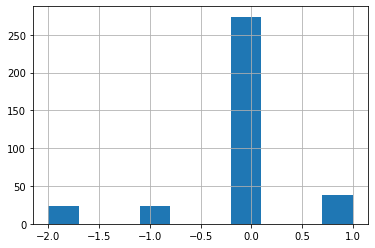

In [ ]:
df.RSI_signal_1.hist()

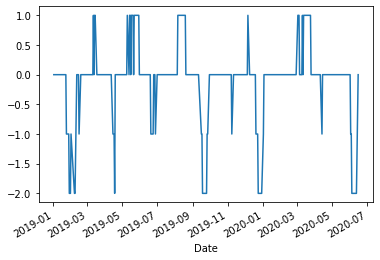

In [ ]:
df.RSI_signal_1.plot()

In [ ]:
df.RSI_signal_2.describe()

count    358.000000
mean       0.011173
std        0.224265
min       -1.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: RSI_signal_2, dtype: float64

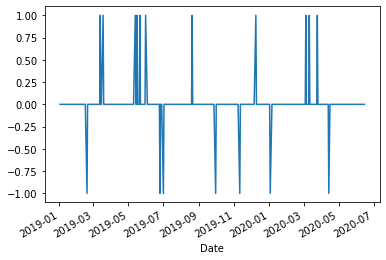

In [ ]:
df.RSI_signal_2.plot()

In [ ]:
df.RSI_signal_3.describe()

count    358.000000
mean       0.000000
std        0.317554
min       -1.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: RSI_signal_3, dtype: float64

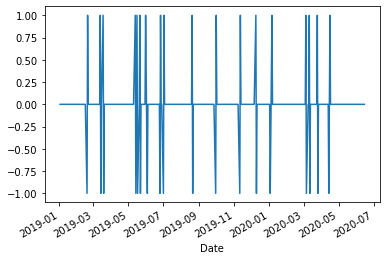

In [ ]:
df.RSI_signal_3.plot()

In [ ]:
df.RSI_signal_3.describe()

count    358.000000
mean       0.000000
std        0.317554
min       -1.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: RSI_signal_3, dtype: float64

In [ ]:
### Signal Visualization Execution 2 ###

bigvalue = {'CL' : 1000, 'GC' : 100, 'KS200':250000, 'US500': 50, 'NDX' : 20, 'N225' : 500, 'DAX' : 25, 'GBP/USD':62500, 'EUR/USD':125000,'USD/JPY' : 12500000,'SI':5000,'HG':2500}
now = datetime.datetime.today().strftime('%Y-%m-%d')

def backtest(ticker, start_date = '2008-01-01', end_date = now, initial=100000000,
             window = 14):
    ## Frame ##
    df = signal_result(ticker, state_date = '2008-01-01', end_date=now, window = 20)

    bt = df[(df.index >= start_date) & (df.index < end_date)]

    ## PNL ##    
    bt['RSI_pnl_new'] = np.where(bt['RSI_signal_3'] >=1, bt['RSI_signal_3']*(bt['Close'] - bt['Open'])*bigvalue[ticker],
                                  (np.where(bt['RSI_signal_3'] <=-1, -bt['RSI_signal_3']*(bt['Close'] - bt['Open'])*bigvalue[ticker], 0)))
     
    
    bt['RSI_signal_3_lag'] = 0
    for i in np.arange(1, len(df['RSI_signal_3'])):
        bt['RSI_signal_3_lag'][i] = bt['RSI_signal_3'][i-1]

    bt['Close_lag'] = 0
    for i in np.arange(1, len(df['Close'])):
        bt['Close_lag'][i] = bt['Close'][i-1]

    bt['RSI_pnl_oldps'] = ((bt['RSI_signal_2'] -  bt['RSI_signal_3_lag']))
    bt['RSI_pnl_old'] = np.where(bt['RSI_pnl_oldps'] > 0, bt['RSI_signal_2']*(bt['Close']-bt['Close_lag'])*bigvalue[ticker],
                                 (np.where(bt['RSI_pnl_oldps'] < 0, bt['RSI_signal_2']*(bt['Close']-bt['Close_lag'])*bigvalue[ticker],0)))
    
    bt['RSI_pnl'] = bt['RSI_pnl_new'] + bt['RSI_pnl_old']

    '''
    bt['PNL_daily_zscore'] = (np.where(bt['Zscore_signal'] ==1,
                                      abs(initial/(bt['Open']*bigvalue[ticker])).astype(int)*(bt['Open'].shift(-1) - bt['Open'])*bigvalue[ticker],
                                      np.where(bt['Zscore_signal'] ==-1,-abs(initial/(bt['Open']*bigvalue[ticker])).astype(int)*(bt['Open'].shift(-1) - bt['Open'])*bigvalue[ticker],
                                               0)))/initial + 1                
    bt['PNL_total_zscore'] = bt['PNL_daily_zscore'].cumprod()-1
    #
    bt['PNL_daily_zscore_roll'] = (np.where(bt['Zscore_roll_signal'] ==1,
                                      abs(initial/(bt['Open']*bigvalue[ticker])).astype(int)*(bt['Open'].shift(-1) - bt['Open'])*bigvalue[ticker],
                                      np.where(bt['Zscore_roll_signal'] ==-1,-abs(initial/(bt['Open']*bigvalue[ticker])).astype(int)*(bt['Open'].shift(-1) - bt['Open'])*bigvalue[ticker],
                                               0)))/initial+1                
    bt['PNL_total_zscore_roll'] = bt['PNL_daily_zscore_roll'].cumprod()-1
    #
    bt['PNL_daily_rsi_spread'] = (np.where(bt['RSI_Spread_Signal'] ==1,
                                      abs(initial/(bt['Open']*bigvalue[ticker])).astype(int)*(bt['Open'].shift(-1) - bt['Open'])*bigvalue[ticker],
                                      np.where(bt['RSI_Spread_Signal'] ==-1,-abs(initial/(bt['Open']*bigvalue[ticker])).astype(int)*(bt['Open'].shift(-1) - bt['Open'])*bigvalue[ticker],
                                               0)))/initial+1                
    bt['PNL_total_rsi_spread'] = bt['PNL_daily_rsi_spread'].cumprod()-1
    '''
    return bt

def benchmark(bt, start_date='2008-01-01', end_date= now, ticker='KS200'):

    df_list_1 = fdr.DataReader(ticker,  "2008-01-01","2008-12-31")[['Open','High','Low','Close']]
    df_list_2 = fdr.DataReader(ticker,  "2009-01-01","2009-12-31")[['Open','High','Low','Close']]
    df_list_3 = fdr.DataReader(ticker,  "2010-01-01","2010-12-31")[['Open','High','Low','Close']]
    df_list_4 = fdr.DataReader(ticker,  "2011-01-01","2011-12-31")[['Open','High','Low','Close']]
    df_list_5 = fdr.DataReader(ticker,  "2012-01-01","2012-12-31")[['Open','High','Low','Close']]
    df_list_6 = fdr.DataReader(ticker,  "2013-01-01","2013-12-31")[['Open','High','Low','Close']]
    df_list_7 = fdr.DataReader(ticker,  "2014-01-01","2014-12-31")[['Open','High','Low','Close']]
    df_list_8 = fdr.DataReader(ticker, "2015-01-01","2015-12-31")[['Open','High','Low','Close']]
    df_list_9 =fdr.DataReader(ticker,  "2016-01-01","2016-12-31")[['Open','High','Low','Close']]
    df_list_10 =fdr.DataReader(ticker, "2017-01-01","2017-12-31")[['Open','High','Low','Close']]
    df_list_11 =fdr.DataReader(ticker, "2018-01-01","2018-12-31")[['Open','High','Low','Close']]
    df_list_12 =fdr.DataReader(ticker, "2019-01-01","2019-12-31")[['Open','High','Low','Close']]
    df_list_13 =fdr.DataReader(ticker, "2020-01-01")[['Open','High','Low','Close']]
                
    df_total = pd.concat([df_list_1, df_list_2, df_list_3, df_list_4,df_list_5, df_list_6, df_list_7, df_list_8,
                          df_list_9, df_list_10, df_list_11, df_list_12, df_list_13]) 
    # NA cleaning
    df_raw0 = df_total[['Open','High','Low']]
    df_raw = df_total['Close']
    df_raw = df_raw.fillna(method = 'ffill')

    bench = df_raw / df_raw.shift(1)
    bench2 = bench.cumprod()-1
    bt['Benchmark'] = bench2

def hpr_result(bt):
    bt['RSI_pnl_2'] = (bt['RSI_pnl'] / initial + 1).cumprod()-1
    a = bt['RSI_pnl_2']
    return a[-2]

In [ ]:
b = hpr_result(result)
b

NameError: ignored

In [ ]:
def mdd(bt, initial =1000000):

    bt['RSI_pnl_2'] = (bt['RSI_pnl'])/initial+1
    bt['RSI_pnl_3'] = bt['RSI_pnl_2'].cumprod()
    bt['RSI_dd'] = (bt['RSI_pnl_3'].cummax() - bt['RSI_pnl_3'])/ bt['RSI_pnl_3'].cummax() * 100
    mdd = bt['RSI_dd'].max()
    
    return mdd

    '''bt['PNL_daily_zscore_2'] = (np.where(bt['Zscore_signal'] ==1,
                                      abs(initial/(bt['Open']*bigvalue[ticker])).astype(int)*(bt['Open'].shift(-1) - bt['Open'])*bigvalue[ticker],
                                      np.where(bt['Zscore_signal'] ==-1,-abs(initial/(bt['Open']*bigvalue[ticker])).astype(int)*(bt['Open'].shift(-1) - bt['Open'])*bigvalue[ticker],
                                               0)))/initial + 1                
    bt['PNL_total_zscore_2'] = bt['PNL_daily_zscore_2'].cumprod()
    #
    bt['PNL_daily_zscore_roll_2'] = (np.where(bt['Zscore_roll_signal'] ==1,
                                      abs(initial/(bt['Open']*bigvalue[ticker])).astype(int)*(bt['Open'].shift(-1) - bt['Open'])*bigvalue[ticker],
                                      np.where(bt['Zscore_roll_signal'] ==-1,-abs(initial/(bt['Open']*bigvalue[ticker])).astype(int)*(bt['Open'].shift(-1) - bt['Open'])*bigvalue[ticker],
                                               0)))/initial+1                
    bt['PNL_total_zscore_roll_2'] = bt['PNL_daily_zscore_roll_2'].cumprod()
    #
    bt['PNL_daily_rsi_spread_2'] = (np.where(bt['RSI_Spread_Signal'] ==1,
                                      abs(initial/(bt['Open']*bigvalue[ticker])).astype(int)*(bt['Open'].shift(-1) - bt['Open'])*bigvalue[ticker],
                                      np.where(bt['RSI_Spread_Signal'] ==-1,-abs(initial/(bt['Open']*bigvalue[ticker])).astype(int)*(bt['Open'].shift(-1) - bt['Open'])*bigvalue[ticker],
                                               0)))/initial+1                
    bt['PNL_total_rsi_spread_2'] = bt['PNL_daily_rsi_spread_2'].cumprod()
    #
    bt['mdd_zscore_2'] =(bt['PNL_total_zscore_2'].cummax() - bt['PNL_total_zscore_2']) / bt['PNL_total_zscore_2'].cummax() * 100
    bt['mdd_zscore_rolling_2'] =(bt['PNL_total_zscore_roll_2'].cummax() - bt['PNL_total_zscore_roll_2'])/ bt['PNL_total_zscore_roll_2'].cummax() * 100
    bt['mdd_rsi_spread_2'] =(bt['PNL_total_rsi_spread_2'].cummax() - bt['PNL_total_rsi_spread_2'])/ bt['PNL_total_rsi_spread_2'].cummax() * 100

    mdd_zscore = bt['mdd_zscore_2'].max()
    mdd_zscore_rolling = bt['mdd_zscore_rolling_2'].max()
    mdd_rsi_spread = bt['mdd_rsi_spread_2'].max()

    return mdd_zscore, mdd_zscore_rolling, mdd_rsi_spread'''

In [ ]:
## MDD Results ##
##ticker, start_date, end_date, initial, window(for rsi), window_z(for rolling z score), rsi_spread_point(for signal)
#result = backtest('CL', start_date= '2008-01-01', end_date='2010-01-01',window = 14, window_z=120, rsi_spread_point = 10)
#print(mdd(result))

In [ ]:
### Visualization ###

#ticker_list = ["USD/JPY","EUR/USD","GBP/USD","US500",
#              "JP225","NDX","UK100","EU50","HCEI", "KS200", "DE30",
#               "GC","HG","PA","CL","SI"] 
#ticker = 'CL'
#start_date = '2008-01-01'
#end_date ='2010-01-01'
#window = 14
#window_z =120
#rsi_spread_point =10
ticker = 'KS200'
start_date = '2019-01-01'
end_date = now
window = 14
initial = 1000000

# Setting #
result = backtest(ticker, start_date, end_date,initial, window)

In [ ]:
result.RSI_pnl.plot()

In [ ]:
benchmark(result,  start_date, end_date)



---
HPR results & MDD results


---




In [ ]:
## Results ##
##ticker, start_date, end_date, initial, window(for rsi), window_z(for rolling z score), rsi_spread_point(for signal)
#ticker
#start date
#end date
# window, window_z, rsi_spread_point
hpr_result(result)

In [ ]:
## MDD Results ##
##ticker, start_date, end_date, initial, window(for rsi), window_z(for rolling z score), rsi_spread_point(for signal)

#ticker
#start date
#end date
# window, window_z, rsi_spread_point

result = backtest(ticker, start_date, end_date,initial,window)
print(mdd(result))



---



---



---

Trash Cabin


---



---



---

